### 1. Loading the libraries

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import glob
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# adjust the style to emulate ggplot
plt.style.use('ggplot')

YEARS = [2019, 2020, 2021, 2022, 2023]

### 2. Preliminary analysis using only one month of the bicing status data

In [2]:
bicing_status_cols = ['last_updated', 'station_id', 'num_bikes_available', 'num_docks_available']
bicing_status_2212 = pd.read_csv(r'..\data\raw\bicing_stations_status\2022\2022_12_Desembre_BicingNou_ESTACIONS.csv', usecols=bicing_status_cols)

In [3]:
bicing_status_2212.sample(20)

,station_id,num_bikes_available,num_docks_available,last_updated
1642864,225,17,6,1670825385
2190433,417,14,18,1671150593
106583,288,10,22,1669912499
2906824,389,9,18,1671576285
1459203,384,8,18,1670716182
693436,32,12,2,1670261403
803562,134,4,17,1670326775
220877,484,4,23,1669980301
370036,243,5,20,1670069098
141346,206,0,33,1669933200


In [4]:
bicing_status_2212.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4512523 entries, 0 to 4512522
Data columns (total 4 columns):
 #   Column               Dtype
---  ------               -----
 0   station_id           int64
 1   num_bikes_available  int64
 2   num_docks_available  int64
 3   last_updated         int64
dtypes: int64(4)
memory usage: 137.7 MB


In [5]:
bicing_status_2212.shape

(4512523, 4)

In [6]:
bicing_status_2212.describe().T

,count,mean,std,min,25%,50%,75%,max
station_id,4512523.0,2.615072e+02,149.427218,1.000000e+00,1.320000e+02,2.630000e+02,3.900000e+02,5.190000e+02
num_bikes_available,4512523.0,1.072229e+01,7.664918,0.000000e+00,5.000000e+00,1.000000e+01,1.600000e+01,5.400000e+01
num_docks_available,4512523.0,1.566360e+01,7.858505,0.000000e+00,1.000000e+01,1.600000e+01,2.100000e+01,5.400000e+01
last_updated,4512523.0,1.671189e+09,773538.357338,1.669849e+09,1.670520e+09,1.671190e+09,1.671859e+09,1.672528e+09


In [7]:
bicing_status_2212.memory_usage(deep=True).sum()

144400864

In [8]:
bicing_status_2212.isna().sum()

station_id             0
num_bikes_available    0
num_docks_available    0
last_updated           0
dtype: int64

### 3. Creating a helper functions to clean, add additional features and load the data

In [9]:
def clean_bicing_status(df):
    """Cleans the bicing status DataFrame including converting data types, adding new features, and removing unnecessary columns.

    Args:
        df (DataFrame):

    Returns:
        DataFrame:
    """
    
    def int64_to_uint16(df_):
        cols = df_.select_dtypes('int64')
        return (df_
                .astype({col:'uint16' for col in cols}))

    return (df
            .query('num_bikes_available != 0 and num_docks_available != 0')
            .assign(last_updated=pd.to_datetime(df['last_updated'], unit='s'), 
                    year=lambda df_: df_['last_updated'].dt.year.astype('uint16'),
                    month=lambda df_: df_['last_updated'].dt.month.astype('uint8'),
                    day=lambda df_: df_['last_updated'].dt.day.astype('uint8'),
                    hour=lambda df_: df_['last_updated'].dt.hour.astype('uint8'),)    
            .pipe(int64_to_uint16)
            .drop(columns='last_updated')
    )

In [10]:
clean_bicing_status(bicing_status_2212).sample(25)

,station_id,num_bikes_available,num_docks_available,year,month,day,hour
2907050,105,4,17,2022,12,20,22
133664,92,2,16,2022,12,1,21
2103371,214,3,21,2022,12,15,10
2996484,31,9,9,2022,12,21,13
4071069,424,20,7,2022,12,28,22
4381786,496,1,17,2022,12,31,1
2834136,395,31,1,2022,12,20,10
539361,393,13,18,2022,12,4,16
3110204,438,5,21,2022,12,22,8
1720414,514,3,15,2022,12,12,18


In [11]:
clean_bicing_status(bicing_status_2212).info()

<class 'pandas.core.frame.DataFrame'>
Index: 4258134 entries, 0 to 4512522
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   station_id           uint16
 1   num_bikes_available  uint16
 2   num_docks_available  uint16
 3   year                 uint16
 4   month                uint8 
 5   day                  uint8 
 6   hour                 uint8 
dtypes: uint16(4), uint8(3)
memory usage: 77.2 MB


In [12]:
def load_table(year, month, month_name):
    """Loads the bicing stations data from a CSV file.

    Args:
        year (int): The year of the data.
        month (int): The month of the data.
        month_name (str): The name of the month in Catalan.

    Returns:
        DataFrame: A Pandas DataFrame containing the bicing stations data with columns:
            - last_updated: Timestamp of the last update
            - station_id: ID of the station
            - num_bikes_available: Number of available bikes at the station
            - num_docks_available: Number of available docks at the station
    """
    bicing_status_cols = ['last_updated', 'station_id', 'num_bikes_available', 'num_docks_available']
    file_path = fr'..\data\raw\bicing_stations_status\{year}\{year}_{month:02d}_{month_name}_BicingNou_ESTACIONS.csv'
    try:
        return clean_bicing_status(pd.read_csv(file_path, usecols=bicing_status_cols))
    except FileNotFoundError:
        return None
        

### 4. Loading the bicing status data from 2019 to 2022

In [13]:
i2m = list(zip(range(1, 13), ['Gener', 'Febrer', 'Març', 'Abril', 'Maig', 'Juny', 'Juliol', 'Agost', 'Setembre', 'Octubre', 'Novembre', 'Desembre']))

bicing_status = pd.concat([load_table(year, month, month_name) for year in tqdm(YEARS) for month, month_name in tqdm(i2m) if load_table(year, month, month_name) is not None])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [14]:
bicing_status.head()

,station_id,num_bikes_available,num_docks_available,year,month,day,hour
0,1,16,14,2019,3,28,17
2,3,20,7,2019,3,28,17
3,4,12,7,2019,3,28,17
6,7,26,1,2019,3,28,17
8,9,23,4,2019,3,28,17


In [15]:
bicing_status.shape

(175375027, 7)

In [16]:
bicing_status.isna().sum()

station_id             0
num_bikes_available    0
num_docks_available    0
year                   0
month                  0
day                    0
hour                   0
dtype: int64

In [17]:
bicing_status.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175375027 entries, 0 to 4225971
Data columns (total 7 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   station_id           uint16
 1   num_bikes_available  uint16
 2   num_docks_available  uint16
 3   year                 uint16
 4   month                uint8 
 5   day                  uint8 
 6   hour                 uint8 
dtypes: uint16(4), uint8(3)
memory usage: 3.1 GB


### 5. Creating a helper function for grouping and aggregating monthly data 

In [18]:
def tweak_bicing_status(df):
    """Performs additional tweaks on the data after the cleaning including aggregating data, sorting, and calculating the percentage of docks available and other required features.

    Args:
        df (DataFrame):
        
    Returns:
        DataFrame:
    """
    def float64_to_float32(df_):
        cols = df_.select_dtypes('float64')
        return (df_
                .astype({col:'float32' for col in cols}))

    return (df
            .groupby(by=['station_id', 'year', 'month', 'day', 'hour'], as_index=False).agg({'num_bikes_available': 'median', 'num_docks_available': 'median'})
            .sort_values(by=['station_id', 'year', 'month', 'day', 'hour'])
            .assign(percentage_docks_available=lambda df_: df_['num_docks_available']/(df_['num_docks_available'] + df_['num_bikes_available']),
                    ctx_1=lambda df_: df_['percentage_docks_available'].shift(1),
                    ctx_2=lambda df_: df_['percentage_docks_available'].shift(2),
                    ctx_3=lambda df_: df_['percentage_docks_available'].shift(3),
                    ctx_4=lambda df_: df_['percentage_docks_available'].shift(4),
                )
            .pipe(float64_to_float32)
            .dropna()   # dropping the three rows containing NaNs after .shift()
            .drop(columns=['num_bikes_available', 'num_docks_available'])   # after calculating percentage_docks_available, we no longer need these columns
            .set_index('station_id')    # setting station_id as index temporarily to drop inconsistent stations across yearly data
            .drop([59, 93, 96, 160, 420, 431, 500, 520, 529, 530])
            .reset_index()
            .loc[:, ['station_id', 'year', 'month', 'day', 'hour', 'ctx_1', 'ctx_2', 'ctx_3', 'ctx_4', 'percentage_docks_available']]
    )

In [19]:
bicing_status = tweak_bicing_status(bicing_status)

In [20]:
bicing_status.head(25)

,station_id,year,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,percentage_docks_available
0,1,2019,3,28,21,0.150000,0.383333,0.416667,0.466667,0.033333
1,1,2019,3,28,22,0.033333,0.150000,0.383333,0.416667,0.066667
2,1,2019,3,28,23,0.066667,0.033333,0.150000,0.383333,0.033333
3,1,2019,3,29,0,0.033333,0.066667,0.033333,0.150000,0.034483
4,1,2019,3,29,3,0.034483,0.033333,0.066667,0.033333,0.033333
5,1,2019,3,29,4,0.033333,0.034483,0.033333,0.066667,0.033333
6,1,2019,3,29,5,0.033333,0.033333,0.034483,0.033333,0.033333
7,1,2019,3,29,6,0.033333,0.033333,0.033333,0.034483,0.516667
8,1,2019,3,29,7,0.516667,0.033333,0.033333,0.033333,0.600000
9,1,2019,3,29,8,0.600000,0.516667,0.033333,0.033333,0.883333


In [21]:
bicing_status.shape

(15954877, 10)

In [22]:
bicing_status.isna().sum()

station_id                    0
year                          0
month                         0
day                           0
hour                          0
ctx_1                         0
ctx_2                         0
ctx_3                         0
ctx_4                         0
percentage_docks_available    0
dtype: int64

In [23]:
bicing_status.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15954877 entries, 0 to 15954876
Data columns (total 10 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   station_id                  uint16 
 1   year                        uint16 
 2   month                       uint8  
 3   day                         uint8  
 4   hour                        uint8  
 5   ctx_1                       float32
 6   ctx_2                       float32
 7   ctx_3                       float32
 8   ctx_4                       float32
 9   percentage_docks_available  float32
dtypes: float32(5), uint16(2), uint8(3)
memory usage: 410.8 MB


In [24]:
# converting the bicing_status DataFrame into a parquet file
bicing_status.to_parquet(fr'..\data\processed\bicing_status.parquet')

### 6. Checking the data and performing initial exploratory data analysis (EDA)

In [25]:
bicing_status.groupby(by=['station_id', 'year'], as_index=False).agg({'month': 'nunique'})

,station_id,year,month
0,1,2019,10
1,1,2020,12
2,1,2021,12
3,1,2022,12
4,1,2023,5
...,...,...,...
2417,518,2023,5
2418,519,2020,7
2419,519,2021,12
2420,519,2022,12


In [26]:
(bicing_status
 .select_dtypes('number')
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
)

,station_id,year,month,day,hour,ctx_1,ctx_2,ctx_3,ctx_4,percentage_docks_available
station_id,1.000000,0.085588,-0.007190,0.001289,-0.003417,0.103275,0.103274,0.103274,0.103274,0.103275
year,0.085588,1.000000,-0.301495,-0.009994,-0.004680,0.028638,0.028624,0.028608,0.028588,0.028650
month,-0.007190,-0.301495,1.000000,0.013975,0.001692,0.055761,0.055793,0.055833,0.055876,0.055749
day,0.001289,-0.009994,0.013975,1.000000,0.002566,0.000199,0.000195,0.000207,0.000221,0.000207
hour,-0.003417,-0.004680,0.001692,0.002566,1.000000,0.053410,0.060015,0.064961,0.065169,0.043406
ctx_1,0.103275,0.028638,0.055761,0.000199,0.053410,1.000000,0.882764,0.761836,0.657506,0.882764
ctx_2,0.103274,0.028624,0.055793,0.000195,0.060015,0.882764,1.000000,0.882764,0.761836,0.761836
ctx_3,0.103274,0.028608,0.055833,0.000207,0.064961,0.761836,0.882764,1.000000,0.882764,0.657506
ctx_4,0.103274,0.028588,0.055876,0.000221,0.065169,0.657506,0.761836,0.882764,1.000000,0.565483
percentage_docks_available,0.103275,0.028650,0.055749,0.000207,0.043406,0.882764,0.761836,0.657506,0.565483,1.000000


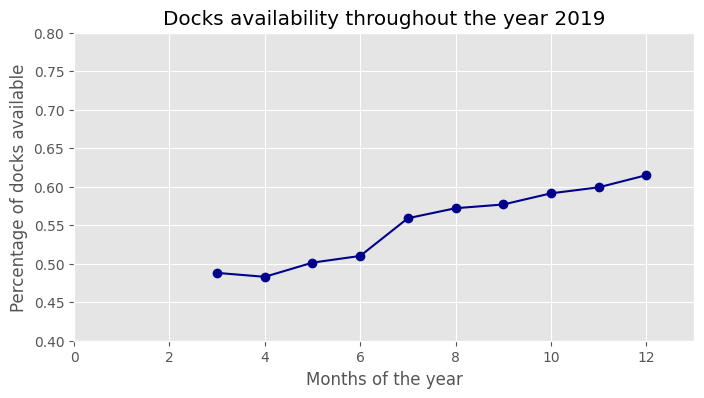

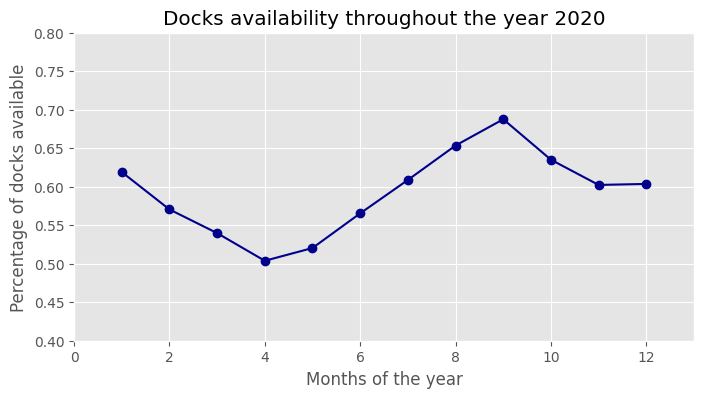

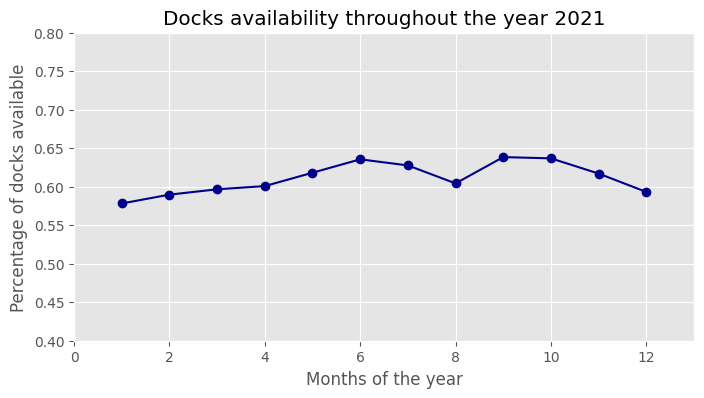

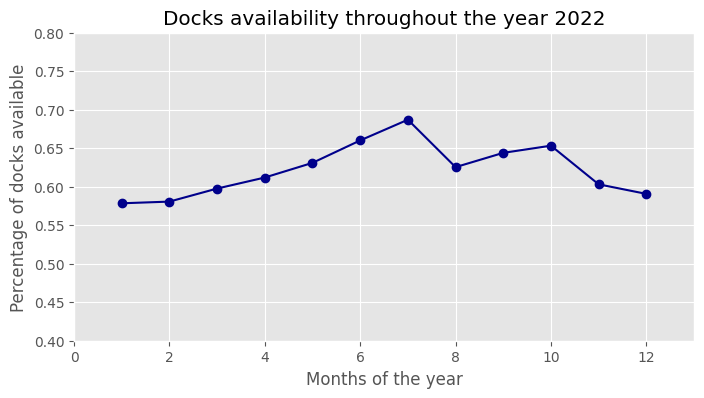

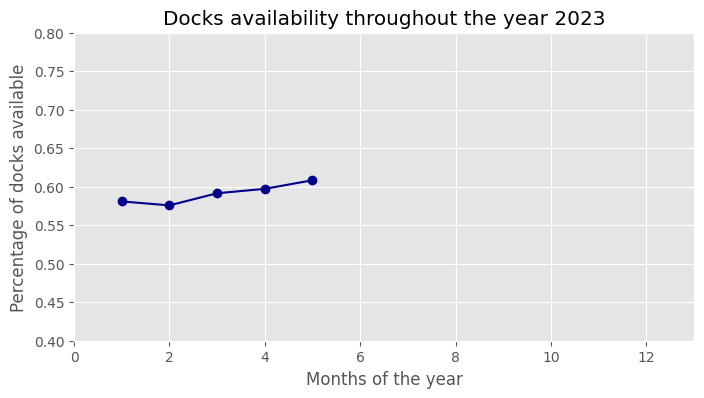

In [27]:
for year in YEARS:
    
    fig, ax = plt.subplots(figsize=(8, 4))
    
    (bicing_status
     .query(f'year == {year}')
     .groupby(by=['month'])['percentage_docks_available'].mean()
     .plot(ax=ax, xlim=(0, 13), ylim=(0.4, 0.8), c='darkblue', marker='o')
    )
    
    plt.xlabel('Months of the year')
    plt.ylabel('Percentage of docks available')
    plt.title(f'Docks availability throughout the year {year}')

### 7. Loading and cleaning meteorological data

In [28]:
meteo_stats_22 = pd.read_csv(r'..\data\raw\meteo_stats\2022\2022_MeteoCat_Detall_Estacions.csv', parse_dates=['DATA_LECTURA'], usecols=['DATA_LECTURA', 'CODI_ESTACIO', 'ACRÒNIM', 'VALOR'])
meteo_stats_22.head()

,DATA_LECTURA,CODI_ESTACIO,ACRÒNIM,VALOR
0,2022-01-01,D5,TM,17.8
1,2022-01-01,D5,TX,21.9
2,2022-01-01,D5,TN,14.8
3,2022-01-01,D5,HRM,33.0
4,2022-01-01,D5,HRX,62.0


In [29]:
meteo_stats_22.dtypes

DATA_LECTURA    datetime64[ns]
CODI_ESTACIO            object
ACRÒNIM                 object
VALOR                  float64
dtype: object

In [30]:
meteo_features = ['year', 'month', 'day', 'TM', 'TN', 'TX', 'HRM', 'HRN', 'HRX', 'PPT', 'RS24h', 'PM', 'PN', 'PX', 'VVM10', 'VVX10', 'DVM10', 'DVVX10']
(meteo_stats_22
 .pivot_table(index='DATA_LECTURA', columns='ACRÒNIM', 
              values='VALOR', aggfunc='mean')
 .rename_axis(None, axis='columns')
 .reset_index()
 .assign(year=lambda df_: df_['DATA_LECTURA'].dt.year,
         month=lambda df_: df_['DATA_LECTURA'].dt.month,
         day=lambda df_: df_['DATA_LECTURA'].dt.day)
 .drop(columns='DATA_LECTURA')
 .loc[:, meteo_features]
)

,year,month,day,TM,TN,TX,HRM,HRN,HRX,PPT,RS24h,PM,PN,PX,VVM10,VVX10,DVM10,DVVX10
0,2022,1,1,13.100,8.900,18.550,69.75,43.75,89.75,0.100000,9.133333,1005.966667,1004.766667,1007.000000,2.333333,6.200000,193.666667,276.000000
1,2022,1,2,12.050,7.900,15.725,78.75,48.50,98.75,0.000000,8.766667,1006.833333,1005.766667,1007.966667,1.600000,6.200000,250.666667,285.666667
2,2022,1,3,11.700,8.550,16.050,79.00,52.00,94.25,0.033333,7.933333,1002.700000,996.666667,1007.266667,1.966667,7.100000,249.000000,250.333333
3,2022,1,4,14.225,9.950,20.500,68.75,44.25,96.50,0.000000,8.833333,989.966667,983.600000,996.700000,2.600000,7.433333,259.000000,114.666667
4,2022,1,5,9.850,6.575,13.175,74.00,43.75,97.75,10.066667,4.933333,989.066667,983.733333,993.100000,3.200000,11.866667,331.000000,256.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2022,12,27,13.600,10.350,18.675,74.50,51.50,93.25,0.000000,8.366667,1008.633333,1007.366667,1010.500000,1.733333,6.033333,257.000000,244.666667
361,2022,12,28,12.750,9.425,17.700,75.25,58.50,89.00,0.000000,8.566667,1003.733333,1000.766667,1007.433333,2.800000,7.800000,260.666667,248.333333
362,2022,12,29,13.450,9.575,18.675,62.50,42.00,80.00,0.000000,6.366667,999.633333,998.133333,1001.066667,2.466667,7.900000,274.666667,293.666667
363,2022,12,30,15.250,11.800,18.300,62.00,48.50,77.00,0.000000,5.000000,1000.233333,998.233333,1003.400000,3.200000,12.233333,283.333333,311.666667



| Field name   | First instance | Description                                   | Unit  | Rename as                              |
|--------------|----------------|-----------------------------------------------|-------|----------------------------------------|
| DATA_LECTURA | 2019           | Date of registration of the measure           |   -   |                    -                   |
| TM           | 2019           | Average daily temperature                     | ºC    | <code>avg_temp</code>                  |
| TN           | 2019           | Minimum daily temperature                     | ºC    | <code>min_temp</code>                  |
| TX           | 2019           | Maximum daily temperature                     | ºC    | <code>max_temp</code>                  |
| HRM          | 2019           | Average daily relative humidity               | %     | <code>avg_rel_humidity</code>          |
| HRN          | -              | Minimum daily relative humidity               | %     | <code>min_rel_humidity</code>          |
| HRX          | -              | Maximum daily relative humidity               | %     | <code>max_rel_humidity</code>          |
| RS24H        | 2019           | Daily global solar radiation                  | MJ/m2 | <code>global_solar_rad</code>          |
| PPT/PPT24H   | 2019           | Accumulated daily precipitation               | mm    | <code>acum_precipitation</code>        |
| PM/HPA       | 2019           | Average daily atmospheric pressure            | hPa   | <code>avg_atm_pressure</code>          |
| PN           | -              | Minimum daily atmospheric pressure            | hPa   | <code>min_atm_pressure</code>          |
| PX           | -              | Maximum daily atmospheric pressure            | hPa   | <code>max_atm_pressure</code>          |
| VVM10        | 2019           | Average daily wind speed (sensors at 10m)     | m/s   | <code>avg_wind_speed</code>            |
| VVX10        | 2019           | Maximum daily wind speed 10m                  | m/s   | <code>max_wind_speed</code>            |
| DVM10        | 2019           | Average daily wind direction (sensors at 10m) | º     | <code>avg_wind_direction</code>        |
| DVVX10       | 2019           | Direction of the streak max. daily wind 10m   | º     | <code>max_streak_wind_direction</code> |

In [31]:
meteo_stats_19_fabra = pd.read_csv(r'..\data\raw\meteo_stats\2019\2019_d5_observatori_fabra.csv', parse_dates=['DATA_LECTURA'])
meteo_stats_19_fabra

,CODI_ESTACIO,DATA_LECTURA,TM,TX,TN,HRM,PPT24H,HPA,RS24H,VVM10,DVM10,VVX10,DVX10
0,D5,01/01/1996,13.2,17.7,10.0,NaN,0.0,955.9,NaN,6.0,NaN,12.5,268.0
1,D5,02/01/1996,11.3,15.4,9.2,NaN,0.0,965.6,NaN,7.3,NaN,16.6,310.0
2,D5,03/01/1996,9.9,14.7,6.6,63.0,0.0,969.9,NaN,6.7,NaN,NaN,NaN
3,D5,04/01/1996,10.3,12.5,NaN,63.0,0.0,967.0,NaN,4.1,NaN,10.1,268.0
4,D5,05/01/1996,9.8,13.3,6.6,87.0,1.2,956.0,NaN,4.6,NaN,11.8,314.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,D5,27/12/2019,9.7,13.0,6.6,70.0,0.0,979.1,8.7,5.8,328.0,13.4,313.0
8762,D5,28/12/2019,10.1,13.1,8.2,74.0,0.0,981.0,8.2,1.5,185.0,4.6,123.0
8763,D5,29/12/2019,9.4,12.5,8.2,85.0,0.0,982.6,5.1,1.7,21.0,4.2,199.0
8764,D5,30/12/2019,8.8,12.6,7.6,81.0,0.0,983.0,5.2,3.0,298.0,6.6,290.0


In [32]:
(meteo_stats_19_fabra
 .assign(DATA_LECTURA=pd.to_datetime(meteo_stats_19_fabra['DATA_LECTURA'], dayfirst=True), year=lambda df_: df_['DATA_LECTURA'].dt.year,
         month=lambda df_: df_['DATA_LECTURA'].dt.month, day=lambda df_: df_['DATA_LECTURA'].dt.day)
 .query('year == 2019')
 .drop(columns=['CODI_ESTACIO', 'DATA_LECTURA'])
)

,TM,TX,TN,HRM,PPT24H,HPA,RS24H,VVM10,DVM10,VVX10,DVX10,year,month,day
8401,10.5,14.4,7.8,73.0,0.0,979.6,5.4,3.8,339.0,15.8,315.0,2019,1,1
8402,8.9,12.9,5.9,48.0,0.0,976.5,9.4,8.3,324.0,17.3,318.0,2019,1,2
8403,8.3,12.6,4.9,59.0,0.0,979.0,9.1,4.0,279.0,9.9,313.0,2019,1,3
8404,7.2,11.3,5.3,69.0,0.0,980.6,8.0,2.0,205.0,7.8,290.0,2019,1,4
8405,9.1,15.2,3.2,47.0,0.0,978.6,9.3,10.0,326.0,17.0,317.0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8761,9.7,13.0,6.6,70.0,0.0,979.1,8.7,5.8,328.0,13.4,313.0,2019,12,27
8762,10.1,13.1,8.2,74.0,0.0,981.0,8.2,1.5,185.0,4.6,123.0,2019,12,28
8763,9.4,12.5,8.2,85.0,0.0,982.6,5.1,1.7,21.0,4.2,199.0,2019,12,29
8764,8.8,12.6,7.6,81.0,0.0,983.0,5.2,3.0,298.0,6.6,290.0,2019,12,30


In [33]:
meteo_stats_20 = pd.read_csv(r'..\data\raw\meteo_stats\2020\2020_MeteoCat_Detall_Estacions.csv', parse_dates=['DATA_LECTURA'])
meteo_stats_20.head()

,DATA_LECTURA,DATA_EXTREM,CODI_ESTACIO,ACRÒNIM,VALOR
0,2020-01-01,NaN,D5,TM,7.0
1,2020-01-01,13:30:00,D5,TX,11.5
2,2020-01-01,01:37:00,D5,TN,4.6
3,2020-01-01,NaN,D5,HRM,81.0
4,2020-01-01,20:30:00,D5,HRX,91.0


In [34]:
(meteo_stats_22
 .pivot_table(index='DATA_LECTURA', columns='ACRÒNIM', 
              values='VALOR', aggfunc='mean')
 .rename_axis(None, axis='columns')
 .reset_index()
 .assign(year=lambda df_: df_['DATA_LECTURA'].dt.year,
         month=lambda df_: df_['DATA_LECTURA'].dt.month,
         day=lambda df_: df_['DATA_LECTURA'].dt.day)
 .drop(columns='DATA_LECTURA')
#  .loc[:, meteo_features]
)

,DVM10,DVVX10,HRM,HRN,HRX,PM,PN,PPT,PX,RS24h,TM,TN,TX,VVM10,VVX10,year,month,day
0,193.666667,276.000000,69.75,43.75,89.75,1005.966667,1004.766667,0.100000,1007.000000,9.133333,13.100,8.900,18.550,2.333333,6.200000,2022,1,1
1,250.666667,285.666667,78.75,48.50,98.75,1006.833333,1005.766667,0.000000,1007.966667,8.766667,12.050,7.900,15.725,1.600000,6.200000,2022,1,2
2,249.000000,250.333333,79.00,52.00,94.25,1002.700000,996.666667,0.033333,1007.266667,7.933333,11.700,8.550,16.050,1.966667,7.100000,2022,1,3
3,259.000000,114.666667,68.75,44.25,96.50,989.966667,983.600000,0.000000,996.700000,8.833333,14.225,9.950,20.500,2.600000,7.433333,2022,1,4
4,331.000000,256.666667,74.00,43.75,97.75,989.066667,983.733333,10.066667,993.100000,4.933333,9.850,6.575,13.175,3.200000,11.866667,2022,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,257.000000,244.666667,74.50,51.50,93.25,1008.633333,1007.366667,0.000000,1010.500000,8.366667,13.600,10.350,18.675,1.733333,6.033333,2022,12,27
361,260.666667,248.333333,75.25,58.50,89.00,1003.733333,1000.766667,0.000000,1007.433333,8.566667,12.750,9.425,17.700,2.800000,7.800000,2022,12,28
362,274.666667,293.666667,62.50,42.00,80.00,999.633333,998.133333,0.000000,1001.066667,6.366667,13.450,9.575,18.675,2.466667,7.900000,2022,12,29
363,283.333333,311.666667,62.00,48.50,77.00,1000.233333,998.233333,0.000000,1003.400000,5.000000,15.250,11.800,18.300,3.200000,12.233333,2022,12,30


In [35]:
meteo_stats_19_path = r'..\data\raw\meteo_stats\2019'
csv_files = glob.glob(meteo_stats_19_path + '/*.csv')

meteo_stats_19 = pd.concat([pd.read_csv(file) for file in tqdm(csv_files)])

  0%|          | 0/4 [00:00<?, ?it/s]

In [36]:
def clean_meteo_stats_19(df):
    return (df
            .assign(DATA_LECTURA=pd.to_datetime(df['DATA_LECTURA'], dayfirst=True), year=lambda df_: df_['DATA_LECTURA'].dt.year,
                    month=lambda df_: df_['DATA_LECTURA'].dt.month, day=lambda df_: df_['DATA_LECTURA'].dt.day)
            .query('year == 2019')
            .drop(columns=['CODI_ESTACIO', 'DATA_LECTURA'])
            .groupby(by=['year', 'month', 'day'], as_index=False).mean()
            .rename(columns={'DVX10': 'DVVX10'})
    )

In [37]:
clean_meteo_stats_19(meteo_stats_19)

,year,month,day,TM,TX,TN,HRM,PPT24H,HPA,RS24H,VVM10,DVM10,VVX10,DVVX10
0,2019,1,1,10.975,15.700,7.025,72.25,0.0,1007.700000,7.000000,2.166667,319.000000,10.900000,306.333333
1,2019,1,2,9.600,14.750,6.200,52.50,0.0,1004.600000,9.233333,3.666667,299.000000,11.266667,310.333333
2,2019,1,3,8.750,13.175,5.225,60.00,0.0,1007.333333,8.933333,2.133333,273.333333,6.833333,294.000000
3,2019,1,4,7.650,11.975,4.400,67.75,0.0,1009.066667,7.866667,1.366667,197.000000,5.566667,178.000000
4,2019,1,5,9.475,15.225,4.950,51.25,0.0,1006.766667,9.233333,5.033333,301.333333,11.766667,297.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019,12,27,10.675,13.950,7.850,70.25,0.0,1007.266667,8.666667,3.066667,305.666667,9.966667,314.666667
361,2019,12,28,10.500,14.525,7.125,77.25,0.0,1009.133333,8.033333,1.066667,173.000000,4.366667,135.666667
362,2019,12,29,11.425,14.050,9.925,78.00,0.0,1010.833333,6.166667,1.200000,122.333333,4.033333,221.666667
363,2019,12,30,10.700,14.125,7.925,75.50,0.0,1011.333333,4.866667,1.666667,309.000000,5.233333,249.333333


In [38]:
def clean_meteo_stats(df):
    return (df
            .pivot_table(index='DATA_LECTURA', columns='ACRÒNIM',
                         values='VALOR', aggfunc='mean')
            .rename_axis(None, axis='columns')
            .reset_index()
            .assign(year=lambda df_: df_['DATA_LECTURA'].dt.year,
                    month=lambda df_: df_['DATA_LECTURA'].dt.month,
                    day=lambda df_: df_['DATA_LECTURA'].dt.day)
            .drop(columns=['DATA_LECTURA', 'HRN', 'HRX', 'PN', 'PX'])
        
    )

In [39]:
def load_meteo_stats(year):
    
    if year == 2019:
        meteo_stats_19_path = r'..\data\raw\meteo_stats\2019'
        csv_files = glob.glob(meteo_stats_19_path + '/*.csv')
        
        meteo_stats_19 = pd.concat([pd.read_csv(file) for file in tqdm(csv_files)])
        
        return clean_meteo_stats_19(meteo_stats_19)
        
    else:
        file_path = fr'..\data\raw\meteo_stats\{year}\{year}_MeteoCat_Detall_Estacions.csv'
        try:
            return clean_meteo_stats(pd.read_csv(file_path, parse_dates=['DATA_LECTURA']))
        except FileNotFoundError:
            return None

In [40]:
def tweak_meteo_stats(df):

    def int_to_uint16(df_):
        cols = df_.select_dtypes(int)
        return (df_
                .astype({col:'uint16' for col in cols}))
    
    def float64_to_float32(df_):
        cols = df_.select_dtypes('float64')
        return (df_
                .astype({col:'float32' for col in cols}))
    
    return (df
            .rename(columns={'TM': 'avg_temp', 'TN': 'min_temp', 'TX': 'max_temp', 
                            'HRM': 'avg_rel_humidity', 'PPT': 'acum_precipitation', 
                            'PPT24H': 'acum_precipitation', 'RS24h': 'global_solar_rad', 'RS24H': 'global_solar_rad', 
                            'PM': 'avg_atm_pressure', 'HPA': 'avg_atm_pressure', 'VVM10': 'avg_wind_speed', 
                            'VVX10': 'max_wind_speed', 'DVM10': 'avg_wind_direction', 'DVVX10': 'max_streak_wind_direction'})
            .pipe(int_to_uint16)
            .pipe(float64_to_float32)
            )

In [41]:
meteo_stats = pd.concat([tweak_meteo_stats(load_meteo_stats(year)) for year in tqdm(YEARS)])
meteo_stats

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,year,month,day,avg_temp,max_temp,min_temp,avg_rel_humidity,acum_precipitation,avg_atm_pressure,global_solar_rad,avg_wind_speed,avg_wind_direction,max_wind_speed,max_streak_wind_direction
0,2019,1,1,10.975000,15.700000,7.025,72.25,0.0,1007.700012,7.000000,2.166667,319.000000,10.900000,306.333344
1,2019,1,2,9.600000,14.750000,6.200,52.50,0.0,1004.599976,9.233334,3.666667,299.000000,11.266666,310.333344
2,2019,1,3,8.750000,13.175000,5.225,60.00,0.0,1007.333313,8.933333,2.133333,273.333344,6.833333,294.000000
3,2019,1,4,7.650000,11.975000,4.400,67.75,0.0,1009.066650,7.866667,1.366667,197.000000,5.566667,178.000000
4,2019,1,5,9.475000,15.225000,4.950,51.25,0.0,1006.766663,9.233334,5.033333,301.333344,11.766666,297.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,2023,5,26,18.100000,21.950001,13.875,80.00,0.0,999.633362,27.533333,2.066667,103.333336,7.000000,85.000000
146,2023,5,27,21.450001,26.750000,16.725,59.50,0.0,996.766663,27.933332,2.433333,232.666672,7.766667,221.000000
147,2023,5,28,21.575001,26.424999,17.600,56.25,0.0,993.033325,28.066668,3.100000,241.333328,9.133333,223.333328
148,2023,5,29,19.600000,23.250000,17.000,73.25,0.0,993.166687,26.366667,2.133333,103.666664,7.366667,176.000000


In [42]:
meteo_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1611 entries, 0 to 149
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   year                       1611 non-null   uint16 
 1   month                      1611 non-null   uint16 
 2   day                        1611 non-null   uint16 
 3   avg_temp                   1611 non-null   float32
 4   max_temp                   1611 non-null   float32
 5   min_temp                   1611 non-null   float32
 6   avg_rel_humidity           1611 non-null   float32
 7   acum_precipitation         1611 non-null   float32
 8   avg_atm_pressure           1611 non-null   float32
 9   global_solar_rad           1611 non-null   float32
 10  avg_wind_speed             1611 non-null   float32
 11  avg_wind_direction         1611 non-null   float32
 12  max_wind_speed             1611 non-null   float32
 13  max_streak_wind_direction  1611 non-null   float32
dty

In [43]:
meteo_stats.isna().sum()

year                         0
month                        0
day                          0
avg_temp                     0
max_temp                     0
min_temp                     0
avg_rel_humidity             0
acum_precipitation           0
avg_atm_pressure             0
global_solar_rad             0
avg_wind_speed               0
avg_wind_direction           0
max_wind_speed               0
max_streak_wind_direction    0
dtype: int64

In [44]:
# converting the meteo_stats DataFrame into a parquet file
meteo_stats.to_parquet(fr'..\data\processed\meteo_stats.parquet')

### 8. Loading and cleaning the bicing info data

In [23]:
info_cols = ['station_id', 'name', 'lat', 'lon', 'altitude', 'post_code', 'capacity']
bicing_info_0323 = pd.read_csv(r'..\data\raw\bicing_stations_info\2023_03_Marc_BicingNou_INFORMACIO.csv', usecols=info_cols)
bicing_info_0323.head()

,station_id,name,lat,lon,altitude,post_code,capacity
0,1,"GRAN VIA CORTS CATALANES, 760",41.397978,2.180107,16,8013,46
1,2,"C/ ROGER DE FLOR, 126",41.395488,2.177198,17,8013,29
2,3,"C/ NÀPOLS, 82",41.394156,2.181331,11,8013,27
3,4,"C/ RIBES, 13",41.393317,2.181248,8,8013,21
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",41.391103,2.180176,7,8018,39


In [24]:
(bicing_info_0323
 .groupby(['station_id', 'name', 'post_code'], as_index=False)
 .agg({'lat': 'mean', 'lon': 'mean', 'altitude': 'mean', 'capacity': 'max'})
 .describe().T
)

,count,mean,std,min,25%,50%,75%,max
station_id,517.0,258.613153,149.257533,1.000000,129.000000,259.000000,386.000000,519.000000
post_code,517.0,8021.357834,41.659444,8001.000000,8011.000000,8018.000000,8029.000000,8930.000000
lat,517.0,41.399382,0.020989,41.346775,41.383467,41.395409,41.411663,41.462095
lon,517.0,2.167992,0.024311,2.109154,2.150342,2.170393,2.187093,2.220691
altitude,517.0,34.980658,32.207233,2.000000,9.000000,24.000000,52.000000,166.000000
capacity,517.0,27.052224,6.426325,12.000000,24.000000,27.000000,29.000000,54.000000


In [39]:
(bicing_info_0323
 .groupby(['station_id', 'name','post_code'], as_index=False)
 .agg({'lat': 'mean', 'lon': 'mean', 'altitude': 'mean', 'capacity': 'max'})
 .astype({'station_id': 'uint16', 'post_code': 'category', 'lat': 'float32', 'lon': 'float32', 'altitude': 'uint16', 'capacity': 'uint8'})
 .drop_duplicates(subset='station_id')
)

,station_id,name,post_code,lat,lon,altitude,capacity
0,1,"GRAN VIA CORTS CATALANES, 760",8013,41.397980,2.180107,16,46
1,2,"C/ ROGER DE FLOR, 126",8013,41.395489,2.177198,17,29
2,3,"C/ NÀPOLS, 82",8013,41.394157,2.181330,11,27
3,4,"C/ RIBES, 13",8013,41.393318,2.181248,8,21
4,5,"PG. LLUIS COMPANYS, 11 (ARC TRIOMF)",8018,41.391102,2.180176,7,39
...,...,...,...,...,...,...,...
512,515,"C/ SANT ADRIÀ, 43",8030,41.435207,2.194800,19,24
513,516,"C/ SANT ADRIÀ, 88",8030,41.435459,2.200157,15,21
514,517,"AV. RASOS DE PEGUERA, 10",8033,41.462093,2.178959,44,20
515,518,"C/ LLOBREGÓS, 115",8032,41.424690,2.157049,112,27


In [40]:
def tweak_bicing_info(df):
    return (df
            .groupby(['station_id', 'name', 'post_code'], as_index=False)
            .agg({'lat': 'mean', 'lon': 'mean', 'altitude': 'mean', 'capacity': 'max'})
            .astype({'station_id': 'uint16', 'post_code': 'category', 
                     'lat': 'float32', 'lon': 'float32', 'altitude': 'uint16', 
                     'capacity': 'uint8'})
            .drop_duplicates(subset='station_id')
    )

In [41]:
bicing_info = tweak_bicing_info(bicing_info_0323)

In [42]:
bicing_info.dtypes

station_id      uint16
name            object
post_code     category
lat            float32
lon            float32
altitude        uint16
capacity         uint8
dtype: object

In [43]:
bicing_info.to_parquet(fr'..\data\processed\bicing_info.parquet')